In [1]:
import os
import sys
file_path = os.path.abspath('../utils')
print(file_path)
sys.path.append(file_path)
import CommonUtil as cu    # ct_win

import glob
import h5py
import cv2
import numpy as np
from tqdm import tqdm, tqdm_notebook
import shutil
import json
import SimpleITK as sitk
import matplotlib.pylab as plt
from skimage.transform import resize
from datetime import datetime, timedelta, timezone
import nibabel as nib
import SimpleITK as sitk
import pydicom

/home/gil/gcubme_ai2/Workspace/SB_MUN/20_강의_스마트헬스케어/utils


In [2]:
win_level = 40
win_width = 350

In [3]:
width = 128
height = 128
channel = 1


# data path 가져오기

In [4]:
# 이미지 위치
img_dir = os.path.abspath('./data/data_origin/*')

# 전처리한 데이터 저장할 위치
save_dir = os.path.abspath('./data/data_preprocessing')
os.makedirs(save_dir, exist_ok=True)

print(img_dir)
print(save_dir)
####################################################################################################################################
# 전체 이미지 파일 리스트
img_list = sorted(glob.glob(f'{img_dir}/*.dcm'))
lab_list = [glob.glob(f'{os.path.dirname(path)}/*.nii.gz')[0] for path in img_list]

print(len(img_list), img_list[0])
print(len(lab_list), lab_list[0])

/home/gil/gcubme_ai2/Workspace/SB_MUN/20_강의_스마트헬스케어/project_3/data/data_origin/*
/home/gil/gcubme_ai2/Workspace/SB_MUN/20_강의_스마트헬스케어/project_3/data/data_preprocessing
500 /home/gil/gcubme_ai2/Workspace/SB_MUN/20_강의_스마트헬스케어/project_3/data/data_origin/ABDOMEN_0001/ABDOMEN_0001.dcm
500 /home/gil/gcubme_ai2/Workspace/SB_MUN/20_강의_스마트헬스케어/project_3/data/data_origin/ABDOMEN_0001/ABDOMEN_0001_back.nii.gz


In [5]:
def ct_win(im, wl, ww, dtype, out_range, intercept=-1024, slope=1):    
    """
    Scale CT image represented as a `pydicom.dataset.FileDataset` instance.
    """

    # Convert pixel data from Houndsfield units to intensity:
    # intercept = int(im[(0x0028, 0x1052)].value)
    # slope = int(im[(0x0028, 0x1053)].value)
    data = (slope*im.pixel_array+intercept)

    # Scale intensity:
    return cu.win_scale(data, wl, ww, dtype, out_range)

In [6]:
def load_lab(lab_path):
    lab = sitk.ReadImage(lab_path)
    lab = sitk.GetArrayFromImage(lab)
    lab = np.squeeze(lab).astype(np.float32)
    return lab

img_data = []
lab_data = []
# for a in tqdm_notebook(range(len(img_list))):
for a in tqdm_notebook(range(5)):
    img_path = img_list[a]
    la0_path = glob.glob(f'{os.path.dirname(img_path)}/*_back.nii.gz')[0]
    la1_path = glob.glob(f'{os.path.dirname(img_path)}/*_muscle.nii.gz')[0]
    la2_path = glob.glob(f'{os.path.dirname(img_path)}/*_subcutaneous.nii.gz')[0]
    la3_path = glob.glob(f'{os.path.dirname(img_path)}/*_visceral.nii.gz')[0]

    # 데이터 로드
    dcm = pydicom.dcmread(img_path)
    la0 = load_lab(la0_path)
    la1 = load_lab(la1_path)
    la2 = load_lab(la2_path)
    la3 = load_lab(la3_path)
    
    # 데이터 정규화 (0~255) 및 CT Windowing
    img = ct_win(dcm, win_level, win_width, np.uint8, (0, 255))
    la0 = cv2.normalize(la0, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    la1 = cv2.normalize(la1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    la2 = cv2.normalize(la2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    la3 = cv2.normalize(la3, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
    # 데이터 resize  
    img = np.expand_dims(cv2.resize(img, (width, height)), -1)
    la0 = np.expand_dims(cv2.resize(la0, (width, height)), -1)
    la1 = np.expand_dims(cv2.resize(la1, (width, height)), -1)
    la2 = np.expand_dims(cv2.resize(la2, (width, height)), -1)
    la3 = np.expand_dims(cv2.resize(la3, (width, height)), -1)

    lab = np.concatenate((la0, la1, la2, la3), -1)
    
    # 전처리한 데이터 배열에 쌓기
    img_data.append(img)
    lab_data.append(lab)

img_data = np.array(img_data)
lab_data = np.array(lab_data)

print(img_data.shape, np.min(img_data), np.max(img_data))
print(lab_data.shape, np.min(lab_data), np.max(lab_data))


/tmp/ipykernel_707136/125189136.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for a in tqdm_notebook(range(5)):


  0%|          | 0/5 [00:00<?, ?it/s]

(5, 128, 128, 1) 0 255
(5, 128, 128, 4) 0 255


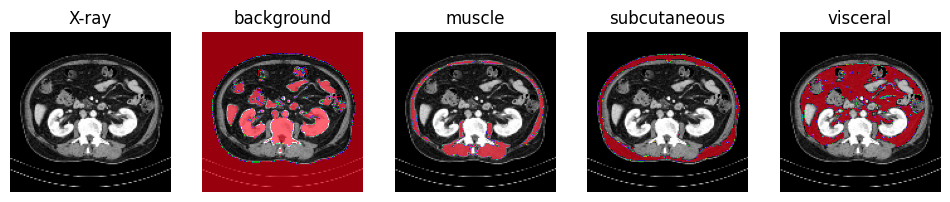

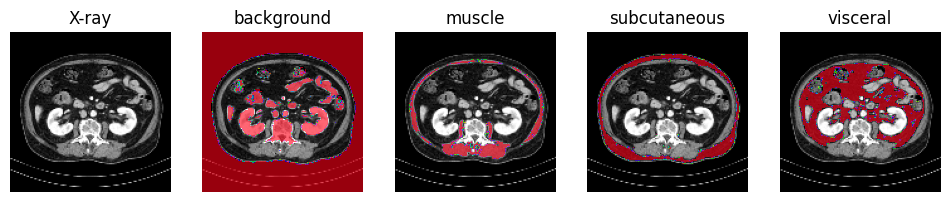

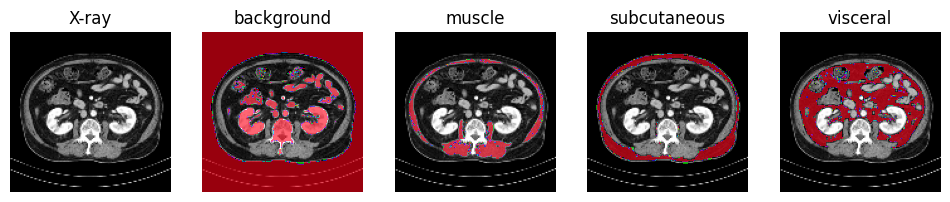

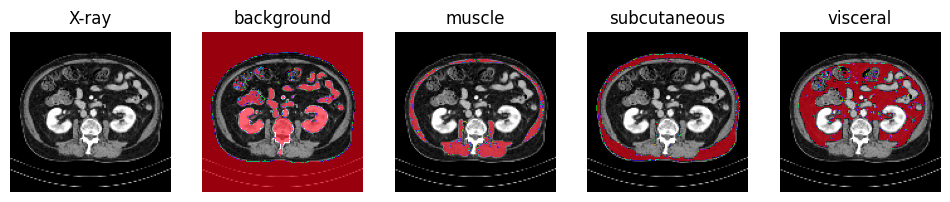

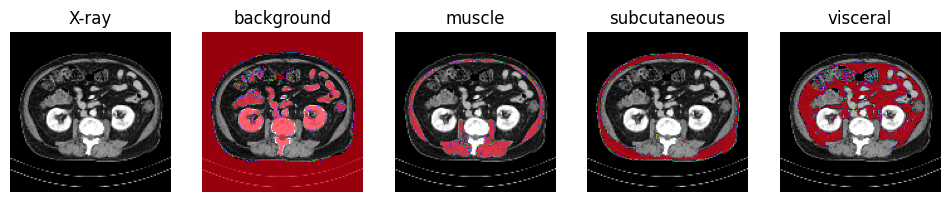

In [7]:
def show_subplot(fig, img, point,cmap='gray', title=''):
    ax = fig.add_subplot(point[0], point[1], point[2])
    ax.imshow(img,cmap=cmap)
    ax.axis('off')
    ax.set_title(f'{title}')
    return ax

def show_subplot_mask(fig, img, mask, point,cmap='gray', title=''):
    ax = fig.add_subplot(point[0], point[1], point[2])
    ax.imshow(img,cmap=cmap)
    tmpMask = mask
    maskedRegion = np.ma.masked_where(tmpMask == 0, tmpMask)
    ax.imshow(maskedRegion,cmap='hsv' ,alpha=0.6)
    ax.axis('off')
    ax.set_title(f'{title}')
    return ax


for i in range(0, len(img_data)):
    img = img_data[i,:,:,0]
    la0 = lab_data[i,:,:,0]
    la1 = lab_data[i,:,:,1]
    la2 = lab_data[i,:,:,2]
    la3 = lab_data[i,:,:,3]
    
    fig = plt.figure(figsize=(12, 12))
    show_subplot(fig, img, (1,5,1), title='X-ray')
    show_subplot_mask(fig, img, la0, (1,5,2), title='background')
    show_subplot_mask(fig, img, la1, (1,5,3), title='muscle')
    show_subplot_mask(fig, img, la2, (1,5,4), title='subcutaneous')
    show_subplot_mask(fig, img, la3, (1,5,5), title='visceral')
    


<Axes: >

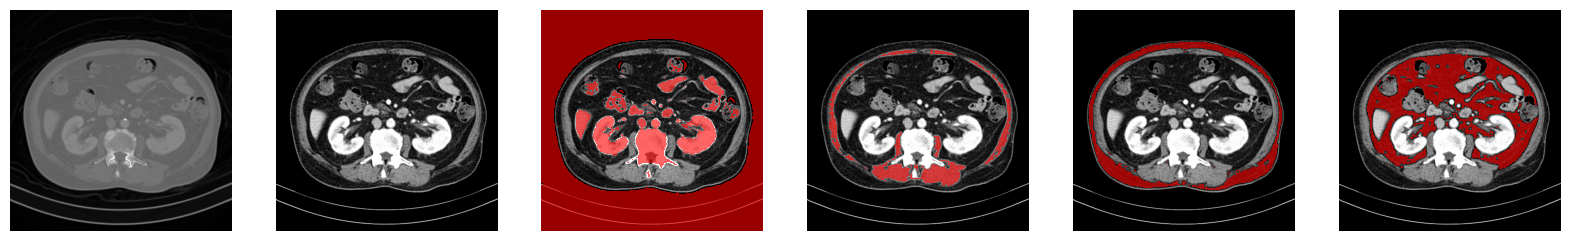

In [10]:
a = 0
img_path = img_list[a]
la0_path = glob.glob(f'{os.path.dirname(img_path)}/*_back.nii.gz')[0]
la1_path = glob.glob(f'{os.path.dirname(img_path)}/*_muscle.nii.gz')[0]
la2_path = glob.glob(f'{os.path.dirname(img_path)}/*_subcutaneous.nii.gz')[0]
la3_path = glob.glob(f'{os.path.dirname(img_path)}/*_visceral.nii.gz')[0]

# 데이터 로드
dcm = pydicom.dcmread(img_path)
la0 = load_lab(la0_path)
la1 = load_lab(la1_path)
la2 = load_lab(la2_path)
la3 = load_lab(la3_path)
img = ct_win(dcm, win_level, win_width, np.uint8, (0, 255))

fig = plt.figure(figsize=(20, 20))
show_subplot(fig, dcm.pixel_array, (1,6,1), title='')
show_subplot(fig, img, (1,6,2), title='')
show_subplot_mask(fig, img, la0, (1,6,3), title='')
show_subplot_mask(fig, img, la1, (1,6,4), title='')
show_subplot_mask(fig, img, la2, (1,6,5), title='')
show_subplot_mask(fig, img, la3, (1,6,6), title='')